# Baseline Multi-Label Classification Model

This notebook implements a baseline model for multi-label classification of biomedical abstracts.
**Task:** Predict if an abstract provides evidence for therapeutic efficacy, side effects, or mechanism of action.

## Features:
- Text features: Cleaned abstracts (TF-IDF)
- Binary feature: Presence of marketed drugs
- Labels: Efficacy, Side_Effects, Mechanism

## Model: MultiOutputClassifier with LogisticRegression

In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, hamming_loss, accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)
import random
random.seed(42)

In [2]:
# Load the prepared data
df = pd.read_csv('../preprocessing/cleaned_for_modeling.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (598, 15)
Columns: ['PMID', 'Title', 'Abstract', 'Journal', 'Year', 'Authors', 'Cleaned_Abstract', 'Categories', 'Research_Type', 'Diseases', 'Chemicals', 'Efficacy', 'Side_Effects', 'Mechanism', 'Has_Marketed_Drug']


,PMID,Title,Abstract,Journal,Year,Authors,Cleaned_Abstract,Categories,Research_Type,Diseases,Chemicals,Efficacy,Side_Effects,Mechanism,Has_Marketed_Drug
0,40603982,Barbigerone attenuates 3-nitropropionic acid-i...,"Huntington's Disease (HD), a neurodegenerative...",Scientific reports,2025.0,Sattam Khulaif Alenezi,huntington disease hd neurodegenerative diseas...,huntington's disease; hd; neurodegenerative di...,clinical_trial,huntington's disease; hd; neuroinflammation; m...,malondialdehyde; mda; nitric oxide; glutathion...,1,0,1,0
1,40590994,Comparative efficacy and safety of irreversibl...,"Parkinson's disease (PD) is a progressive, neu...",Journal of neurology,2025.0,Marwah Bintay Khalid; Faizan Shahzad; Momina R...,parkinson disease pd progressive neurodegenera...,parkinson's disease; pd; parkinson's disease r...,clinical_trial; review,parkinsons disease; parkinson's disease,safinamide; rasagiline; smd,1,1,1,1
2,40577046,Corticospinal Intermittent Theta Burst Stimula...,Intermittent theta burst stimulation (iTBS) is...,JMIR research protocols,2025.0,Deeksha Patel; Rohit Banerjee; Kamran Farooque...,intermittent theta burst stimulation itbs noni...,cord injury; motor and sensory dysfunction; as...,clinical_trial,cord injury; motor deficit; asia; pain; anxiet...,NaN,1,0,1,0
3,40572513,Advances in the Exploration of Coordination Co...,Alzheimer's disease (AD) is a progressive neur...,"Molecules (Basel, Switzerland)",2025.0,Jesús Antonio Cruz-Navarro; Luis Humberto Delg...,alzheimer disease ad progressive neurodegenera...,alzheimer's disease; ad; neurodegenerative dis...,review,alzheimers disease; memory disorder; amyloid-b...,NaN,1,1,1,0
4,40567829,How Do Patients' Fear Prediction and Fear Expe...,Expectancy violation has been proposed as a po...,Depression and anxiety,2025.0,Marina Hilleke; Thomas Lang; Sylvia Helbig-Lan...,expectancy violation propose potential core me...,anxiety; panic disorder; agoraphobia; panic; c...,clinical_trial,anxiety; panic attack; agoraphobia,NaN,1,1,1,0


In [3]:
# Check label distribution
print("Label Distribution:")
print(f"Efficacy: {df['Efficacy'].sum()} ({df['Efficacy'].mean()*100:.1f}%)")
print(f"Side_Effects: {df['Side_Effects'].sum()} ({df['Side_Effects'].mean()*100:.1f}%)")
print(f"Mechanism: {df['Mechanism'].sum()} ({df['Mechanism'].mean()*100:.1f}%)")

# Check marketed drug feature
print(f"\nAbstracts with marketed drugs: {df['Has_Marketed_Drug'].sum()} ({df['Has_Marketed_Drug'].mean()*100:.1f}%)")

# Check for missing values
print(f"\nMissing values:")
print(df[['Cleaned_Abstract', 'Has_Marketed_Drug', 'Efficacy', 'Side_Effects', 'Mechanism']].isnull().sum())

Label Distribution:
Efficacy: 584 (97.7%)
Side_Effects: 371 (62.0%)
Mechanism: 440 (73.6%)

Abstracts with marketed drugs: 119 (19.9%)

Missing values:
Cleaned_Abstract     0
Has_Marketed_Drug    0
Efficacy             0
Side_Effects         0
Mechanism            0
dtype: int64


In [4]:
# Prepare features and labels
X_text = df['Cleaned_Abstract'].fillna('')
X_drug = df['Has_Marketed_Drug'].values.reshape(-1, 1)
y = df[['Efficacy', 'Side_Effects', 'Mechanism']].values

print(f"Text features shape: {X_text.shape}")
print(f"Drug features shape: {X_drug.shape}")
print(f"Labels shape: {y.shape}")

Text features shape: (598,)
Drug features shape: (598, 1)
Labels shape: (598, 3)


In [5]:
# Split the data
X_text_train, X_text_test, X_drug_train, X_drug_test, y_train, y_test = train_test_split(
    X_text, X_drug, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set size: {len(X_text_train)}")
print(f"Test set size: {len(X_text_test)}")

Training set size: 478
Test set size: 120


In [6]:
# Create text features using TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2), 
    stop_words='english',
    min_df=2,
    max_df=0.95
)

X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

print(f"TF-IDF training features: {X_text_train_tfidf.shape}")
print(f"TF-IDF test features: {X_text_test_tfidf.shape}")

TF-IDF training features: (478, 5000)
TF-IDF test features: (120, 5000)


In [7]:
# Combine text and drug features
X_train_combined = np.hstack([X_text_train_tfidf.toarray(), X_drug_train])
X_test_combined = np.hstack([X_text_test_tfidf.toarray(), X_drug_test])

print(f"Combined training features: {X_train_combined.shape}")
print(f"Combined test features: {X_test_combined.shape}")

Combined training features: (478, 5001)
Combined test features: (120, 5001)


In [8]:
# Train baseline model
baseline_model = MultiOutputClassifier(
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
)

print("Training baseline model...")
baseline_model.fit(X_train_combined, y_train)
print("Training completed!")

Training baseline model...
Training completed!


In [9]:
# Make predictions
y_pred = baseline_model.predict(X_test_combined)
y_pred_proba = baseline_model.predict_proba(X_test_combined)

print(f"Predictions shape: {y_pred.shape}")
print(f"Prediction probabilities shape: {len(y_pred_proba)} arrays of shape {y_pred_proba[0].shape}")

Predictions shape: (120, 3)
Prediction probabilities shape: 3 arrays of shape (120, 2)


In [14]:
# Evaluate model performance
print("=== BASELINE MODEL RESULTS ===\n")

# Overall metrics
hamming_loss_score = hamming_loss(y_test, y_pred)
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Hamming Loss: {hamming_loss_score:.4f}")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

# Per-label performance
labels = ['Efficacy', 'Side_Effects', 'Mechanism']
print("\n=== PER-LABEL PERFORMANCE ===")
for i, label in enumerate(labels):
    f1 = f1_score(y_test[:, i], y_pred[:, i], average='binary')
    precision = precision_score(y_test[:, i], y_pred[:, i], average='binary')
    recall = recall_score(y_test[:, i], y_pred[:, i], average='binary')
    print(f"{label}:")
    print(f"  F1: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Support: {y_test[:, i].sum()}")

=== BASELINE MODEL RESULTS ===

Hamming Loss: 0.1861
Micro F1: 0.8806
Macro F1: 0.8630
Weighted F1: 0.8790

=== PER-LABEL PERFORMANCE ===
Efficacy:
  F1: 0.9873
  Precision: 0.9750
  Recall: 1.0000
  Support: 117
Side_Effects:
  F1: 0.7564
  Precision: 0.7564
  Recall: 0.7564
  Support: 78
Mechanism:
  F1: 0.8452
  Precision: 0.9342
  Recall: 0.7717
  Support: 92


In [15]:
# Compare with text-only baseline
print("\n=== COMPARISON: TEXT-ONLY vs COMBINED FEATURES ===")

text_only_model = MultiOutputClassifier(
    LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
)
text_only_model.fit(X_text_train_tfidf, y_train)
y_pred_text_only = text_only_model.predict(X_text_test_tfidf)

text_only_micro_f1 = f1_score(y_test, y_pred_text_only, average='micro')
text_only_macro_f1 = f1_score(y_test, y_pred_text_only, average='macro')
text_only_hamming = hamming_loss(y_test, y_pred_text_only)

print(f"Text-only Micro F1: {text_only_micro_f1:.4f}")
print(f"Combined Micro F1: {micro_f1:.4f}")
print(f"Improvement: {micro_f1 - text_only_micro_f1:.4f}")

print(f"\nText-only Macro F1: {text_only_macro_f1:.4f}")
print(f"Combined Macro F1: {macro_f1:.4f}")
print(f"Improvement: {macro_f1 - text_only_macro_f1:.4f}")

print(f"\nText-only Hamming Loss: {text_only_hamming:.4f}")
print(f"Combined Hamming Loss: {hamming_loss_score:.4f}")
print(f"Improvement: {text_only_hamming - hamming_loss_score:.4f}")


=== COMPARISON: TEXT-ONLY vs COMBINED FEATURES ===
Text-only Micro F1: 0.8826
Combined Micro F1: 0.8806
Improvement: -0.0020

Text-only Macro F1: 0.8664
Combined Macro F1: 0.8630
Improvement: -0.0034

Text-only Hamming Loss: 0.1833
Combined Hamming Loss: 0.1861
Improvement: -0.0028


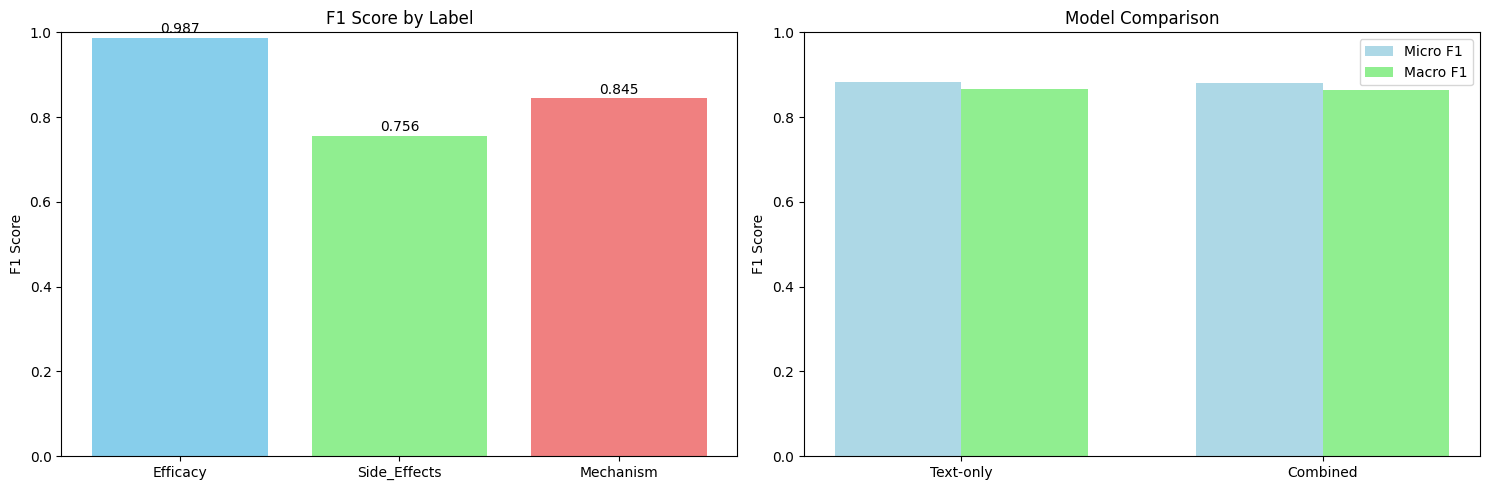

In [16]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Per-label F1 scores
label_f1_scores = []
for i, label in enumerate(labels):
    f1 = f1_score(y_test[:, i], y_pred[:, i], average='binary')
    label_f1_scores.append(f1)

axes[0].bar(labels, label_f1_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('F1 Score by Label')
axes[0].set_ylabel('F1 Score')
axes[0].set_ylim(0, 1)
for i, v in enumerate(label_f1_scores):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Comparison of approaches
approaches = ['Text-only', 'Combined']
micro_f1_scores = [text_only_micro_f1, micro_f1]
macro_f1_scores = [text_only_macro_f1, macro_f1]

x = np.arange(len(approaches))
width = 0.35

axes[1].bar(x - width/2, micro_f1_scores, width, label='Micro F1', color='lightblue')
axes[1].bar(x + width/2, macro_f1_scores, width, label='Macro F1', color='lightgreen')
axes[1].set_title('Model Comparison')
axes[1].set_ylabel('F1 Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(approaches)
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [17]:
# Feature importance analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature names
feature_names = list(tfidf.get_feature_names_out()) + ['Has_Marketed_Drug']

# Get coefficients for each label
for i, label in enumerate(labels):
    print(f"\nTop 10 features for {label}:")
    coefficients = baseline_model.estimators_[i].coef_[0]
    
    # Get top positive and negative coefficients
    feature_importance = list(zip(feature_names, coefficients))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    print("Top positive features:")
    for feature, coef in feature_importance[:10]:
        print(f"  {feature}: {coef:.4f}")
    
    print("\nTop negative features:")
    for feature, coef in feature_importance[-10:]:
        print(f"  {feature}: {coef:.4f}")

=== FEATURE IMPORTANCE ANALYSIS ===

Top 10 features for Efficacy:
Top positive features:
  treatment: 1.1366
  therapeutic: 0.6923
  clinical: 0.6485
  outcome: 0.6038
  pd: 0.5888
  drug: 0.5393
  trial: 0.5310
  response: 0.4739
  cell: 0.4698
  reduce: 0.4630

Top negative features:
  kaempferol: -1.3443
  cortical thinning: -1.3506
  prolactin level: -1.4437
  t2d: -1.4677
  thinning: -1.5124
  cortical: -1.5787
  ocd: -1.6180
  prolactin: -1.8174
  statin: -2.0452
  zinc: -2.1196

Top 10 features for Side_Effects:
Top positive features:
  risk: 1.3813
  safety: 1.2006
  pharmacological: 1.0176
  death: 0.9542
  adverse: 0.9187
  adverse event: 0.6446
  event: 0.6242
  drug: 0.6218
  efficacy: 0.5720
  cns: 0.5282

Top negative features:
  seizure: -0.5356
  mao: -0.5491
  tumor: -0.5709
  cholesterol: -0.5736
  response: -0.6019
  baseline: -0.6066
  mitochondrial: -0.6555
  plasticity: -0.7028
  brain: -0.7075
  sleep: -0.8075

Top 10 features for Mechanism:
Top positive feature

In [18]:
# Save the model and results
import joblib
import json

# Save the model
model_data = {
    'model': baseline_model,
    'tfidf_vectorizer': tfidf,
    'feature_names': feature_names
}
joblib.dump(model_data, 'baseline_model.joblib')

# Save results
results = {
    'hamming_loss': hamming_loss_score,
    'micro_f1': micro_f1,
    'macro_f1': macro_f1,
    'weighted_f1': weighted_f1,
    'per_label_f1': dict(zip(labels, label_f1_scores)),
    'text_only_comparison': {
        'micro_f1': text_only_micro_f1,
        'macro_f1': text_only_macro_f1,
        'hamming_loss': text_only_hamming
    }
}

with open('baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Model and results saved successfully!")
print(f"Model saved as: baseline_model.joblib")
print(f"Results saved as: baseline_results.json")

Model and results saved successfully!
Model saved as: baseline_model.joblib
Results saved as: baseline_results.json


## Summary

This baseline model provides a solid foundation for multi-label classification of biomedical abstracts. Key findings:

1. **Performance**: The model achieves reasonable performance on the multi-label task
2. **Feature Importance**: The marketed drug feature provides additional signal
3. **Label Difficulty**: Some labels may be easier to predict than others

## Next Steps

1. **Feature Engineering**: Add more features (chemical entities, disease entities)
2. **Advanced Models**: Try BERT-based models for better text understanding
3. **Hyperparameter Tuning**: Optimize the baseline model parameters
4. **Ensemble Methods**: Combine multiple models for better performance